# Task 2: 量子模拟器实现

## 背景知识
1. qubit = 比特
2. 基所对应的int用小端表示，即[qubit_number, .... 0], 如对于11110, 0比特的值是0

In [1]:
# 实现的两个包
from circuit import Circuit, CNOT, U3  #
from library import paresGateMatrixPd
import time
from numpy import pi
import numpy as np

## 初始化电路

In [2]:
qubit_numer = 2
qc = Circuit(qubit_numer) # 有两个比特[0,1]

### 电路提供了两种门 CNOT门 和 U3 门。

1. U3 是一个单比特门, 除了连接的比特，有三个参数 theta、lambda、phi。
2. CNOT 是一个两比特门， 除了连接的两个比特，没有参数

In [3]:
u3 = U3(0, pi/2, pi/3, pi/4)  # 参数：作用的比特位置，theta、lambda、phi
qc.addGate(u3)  # 将其加入电路中
u3.matrix()  # 一个u3门对应一个2X2的矩阵

array([[ 0.70710678+0.j        , -0.35355339-0.61237244j],
       [ 0.5       +0.5j       , -0.1830127 +0.6830127j ]])

In [4]:
cnot = CNOT(0,1) # 参数：作用的比特位置
qc.addGate(cnot) 
cnot.matrix()  # 一个cnot门对应一个4X4的矩阵

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

In [5]:
paresGateMatrixPd(cnot.matrix())  # CNOT门来说，0比特是1,1比特翻转（注意是小端）

,00,01,10,11
00,1.0,,,
01,,,,1.0
10,,,1.0,
11,,1.0,,


In [6]:
qiskit_qc = qc.toQiskit()
print(qiskit_qc)  # qiskit上是反着的

     ┌─────────────────┐     
q_0: ┤ U3(π/2,π/4,π/3) ├──■──
     └─────────────────┘┌─┴─┐
q_1: ───────────────────┤ X ├
                        └───┘


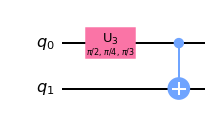

In [7]:
# 也可以画的更好看些
qiskit_qc.draw('mpl')

Circuit.random(gate_number) 用于生成一个随机的电路

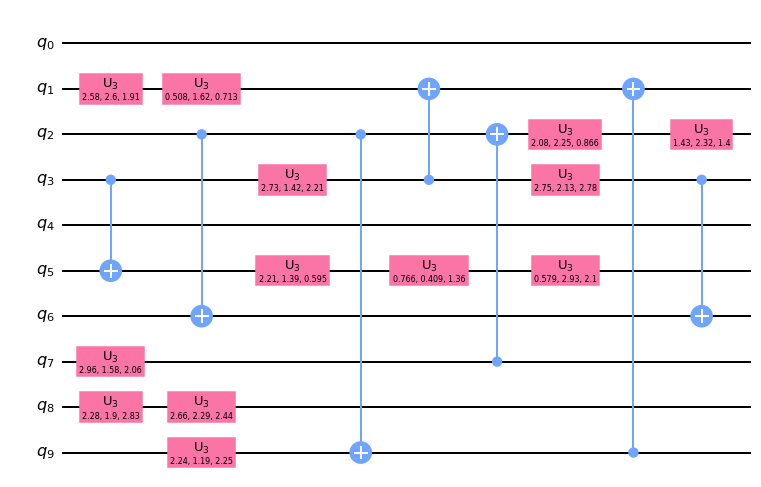

In [8]:
random_qubit_number = 10
random_qc = Circuit(random_qubit_number)
random_qc.random(20)  #电路中门的数量
random_qc.toQiskit().draw('mpl')

## 得到电路所对应的矩阵

In [9]:
random_qc_matrix = random_qc.matrix()
random_qc_matrix

array([[ 0.00583956+0.01603044j,  0.        +0.j        ,
        -0.00913861+0.00128271j, ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.00583956+0.01603044j,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.00791923+0.00495202j,  0.        +0.j        ,
         0.00425733+0.01645824j, ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       ...,
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.01578643+0.00990931j,
         0.        +0.j        , -0.00809395+0.00871769j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.01485393+0.01113855j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j       

In [10]:
random_qc_matrix.shape  # (2**qubit_number, 2**qubit_number)

(1024, 1024)

和开源库对比验证下

In [11]:
from qiskit.quantum_info import Operator
verified_qc = random_qc.toQiskit() # qiskt是小端, 我们这里是大端
verified_qc_matrix = Operator(verified_qc).data
print(np.allclose(random_qc_matrix, verified_qc_matrix))

True


# 任务目标

__完成一个模拟器的库，加快circuit.matrix()的使用，可以使用任何编程语言（python、matlab、C、R，CUDA等），可以使用多进程，分布式等任意方法__

## 需要提交的材料
1. 可执行代码
2. 代码介绍，可以是word、pdf、markdown形式,包含了
    1. 实现介绍
    2. 已有的加速实现方式 + future work（不需要实现）
    3. 测试结果，包含了测试的硬件、软件、电路的规模（比特数、门数量）、计算时间、baseline（本项目提供的代码）在同一台电脑上执行同一个电路计算的时长
    
__请不要作弊，我们会根据你所描述的实现方式预测加速情况，如果测试不合理我们会要求进行一对一的验证__

## 你可能可以尝试的提速的方式


1. 提高代码的并行度，利用并行计算相关的知识；
2. 减少重复计算；
3. 利用一下稀疏矩阵的计算方法进行加速；
4. __研究一下tensor product和permute函数，发现其中的规律（我们可以把它从两个(2**N, 2**N)的矩阵乘法变成一个(2**N, 2**N)和(2,2)的矩阵的乘法)__；
5. 改成蒙特卡洛采样的方法
6. 找到一个电路优化方法，减少需要优化的电路；
7. 互相之间不依赖的门可以并行的计算

······

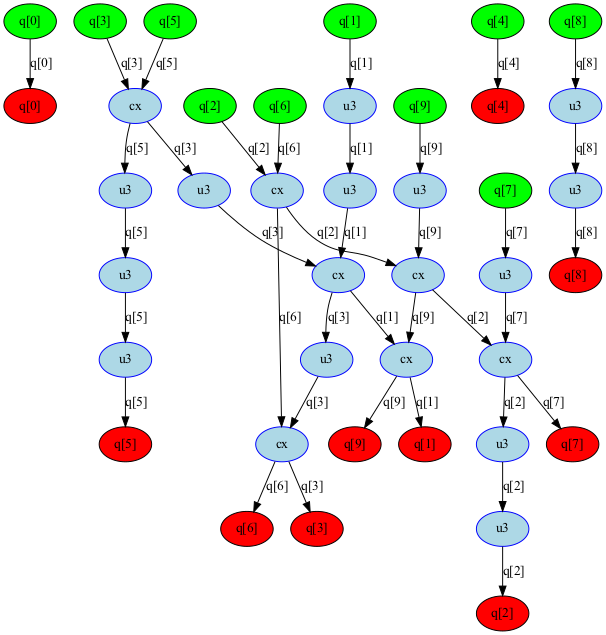

In [14]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import isinstanceint, isinstancelist, dag_to_circuit, circuit_to_dag
dag_circuit =  circuit_to_dag(verified_qc)
dag_circuit.draw()
# 互相之间没有依赖的比特可以张量积成一个矩阵后一起计算